In [1]:
import numpy as np
from scipy.stats import gamma
import torch
from adaptnn.adaptive_layers import AdaptiveLinear
from adaptnn.adaptive_layers import FixedAdaptiveLinear
import matplotlib.pyplot as plt
from scipy.special import expit

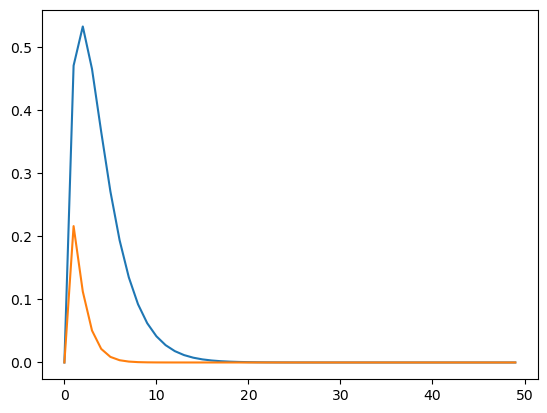

In [2]:
P  = 50
xx = np.arange(0,P)
filter_0 = gamma.pdf(xx, 1.9, scale=2)
filter_1 = gamma.pdf(xx, 1.5, scale=1)
filter_0 = filter_0/np.linalg.norm(filter_0)
filter_1 = filter_1/np.linalg.norm(filter_1)*0.25

b_0 = 1;
b_1 = 0.25;

plt.plot(xx,filter_0)
plt.plot(xx,filter_1)

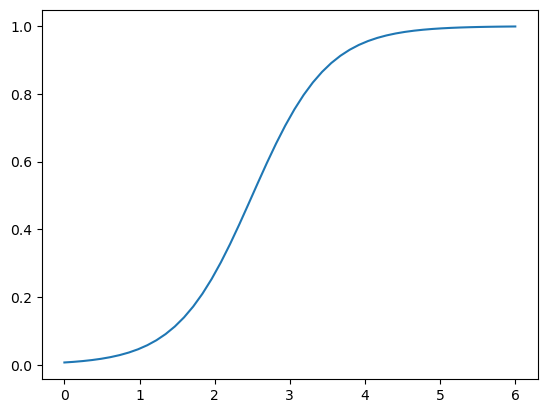

In [3]:
def contrast_function(x):
    return expit(2*(x - 2.5))

cs = np.linspace(0,6,50)
plt.plot(cs, contrast_function(cs))

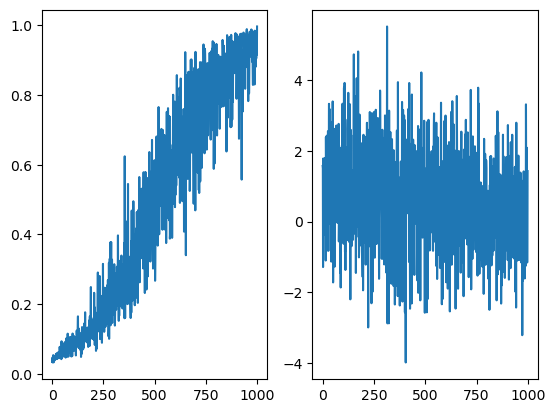

In [4]:
N = 1000
true_contast = np.linspace(1,4,N)
X = np.random.randn(N,P) * true_contast[:,np.newaxis]

noise = np.random.randn(N)*0.1

X_cs = np.std(X,axis=1, keepdims=True)

W = contrast_function(X_cs)

effective_filters = (1-W) @ filter_0[np.newaxis,:] + (W) @ filter_1[np.newaxis,:]

effective_baseline = b_0*(1-W) + W*b_1

X_filt = np.sum(effective_filters*X,axis=1,keepdims=True) + effective_baseline

Y = X_filt.ravel() + noise
plt.subplot(1,2,1)
plt.plot(W)
plt.subplot(1,2,2)
plt.plot(Y)

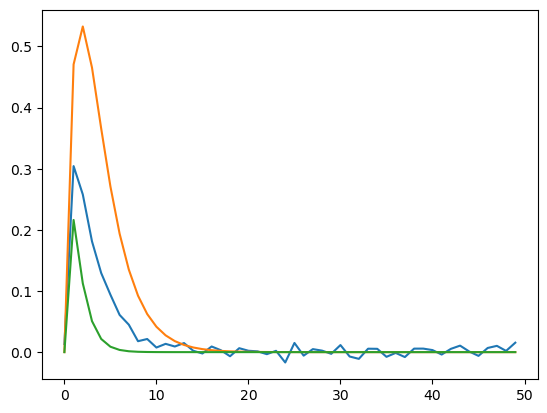

In [5]:
beta_est, *_ = np.linalg.lstsq(np.hstack([X,np.ones((N,1))]) ,Y, rcond=None)
b_est = beta_est[-1]
filt_est = beta_est[:-1]
plt.plot(filt_est)
plt.plot(filter_0)
plt.plot(filter_1)

In [175]:
model = AdaptiveLinear(P, 1,
                       Xa.shape[1], 4)
X_t = torch.tensor(X,dtype=torch.float32)
Xa_t = torch.tensor(Xa,dtype=torch.float32)
Y_t = torch.tensor(Y,dtype=torch.float32).reshape(N,1)
criterion=torch.nn.MSELoss()
learning_rate=0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=4000)

In [177]:
epochs=5000
model.train()
for epoch in range(epochs):
    
    #convert numpy array to torch Variable
    optimizer.zero_grad()
    
    #Forward to get outputs
    outputs=model(X_t,Xa_t)
    
    #calculate loss
    loss=criterion(outputs, Y_t)
    
    #getting gradients wrt parameters
    loss.backward()
    
    #updating parameters
    optimizer.step()
    scheduler.step()
    
    if((epoch+1) % 500 == 0):
        print(f"epoch {epoch+1}, loss {loss.data}, step size {optimizer.param_groups[0]['lr']}")

epoch 500, loss 0.04196011275053024, step size 0.009999999999999959
epoch 1000, loss 0.041918180882930756, step size 0.009999999999999959
epoch 1500, loss 0.04188082367181778, step size 0.009999999999999959
epoch 2000, loss 0.041846901178359985, step size 0.009999999999999959
epoch 2500, loss 0.041814617812633514, step size 0.009999999999999959
epoch 3000, loss 0.041782356798648834, step size 0.009999999999999959
epoch 3500, loss 0.041746046394109726, step size 0.009999999999999959
epoch 4000, loss 0.04171125963330269, step size 0.009999999999999959
epoch 4500, loss 0.04168030247092247, step size 0.009999999999999959
epoch 5000, loss 0.04159064590930939, step size 0.009999999999999959


In [148]:
lbfgs = torch.optim.LBFGS(model.parameters(), max_iter=100, lr=1)
model.train()
def closure():
    if torch.is_grad_enabled():
        optimizer.zero_grad()
    output = model(X_t,Xa_t)
    loss = criterion(output, Y_t)
    if loss.requires_grad:
        loss.backward()
    return loss

for epoch in range(100):
    lbfgs.step(closure)
    output = model(X_t,X_t)
    loss = closure()
    if(epoch % 10 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data ))

epoch 0, loss 0.04335650056600571
epoch 10, loss 0.04173792153596878
epoch 20, loss 0.04058712348341942
epoch 30, loss 0.038299184292554855
epoch 40, loss 0.038286857306957245
epoch 50, loss 0.03828958049416542
epoch 60, loss 0.03830401599407196
epoch 70, loss 0.03827843815088272
epoch 80, loss 0.03828230872750282
epoch 90, loss 0.03844225034117699


Text(0, 0.5, 'true modulator\n(standard deviation of sample -> expit)')

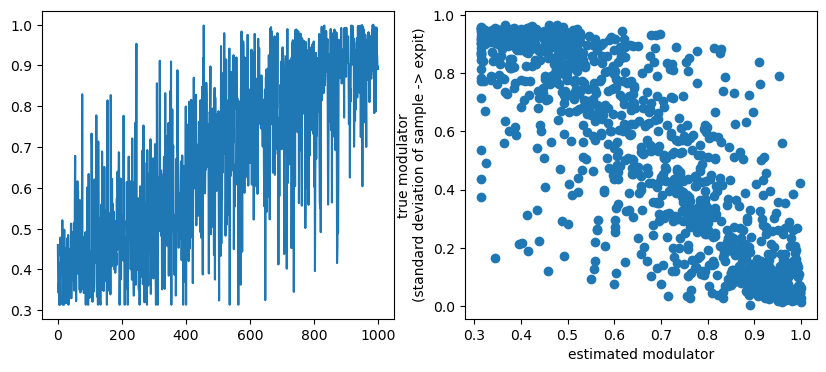

In [180]:
W_t = model.compute_adapt(X_t)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(W_t.numpy())
plt.subplot(1,2,2)
plt.scatter(W_t.numpy(), 1-W)
plt.xlabel("estimated modulator")
plt.ylabel("true modulator\n(standard deviation of sample -> expit)")

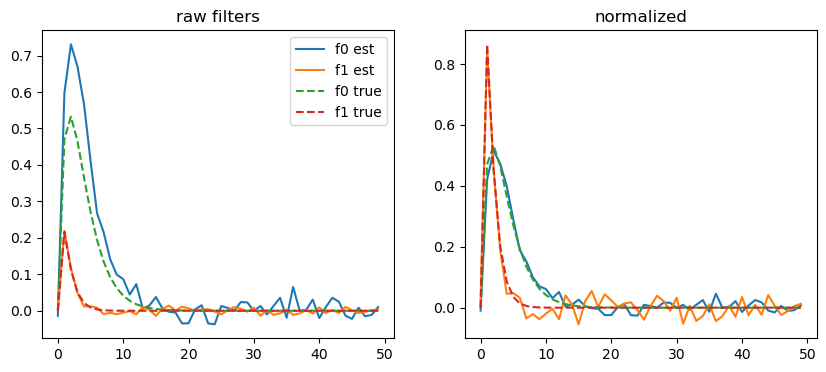

In [179]:

with torch.no_grad():
    filt_0_est = model.B_0.weight[0].numpy()
    filt_1_est = model.B_1.weight[0].numpy()
    Y_est = model(X_t,X_t).numpy()
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(filt_0_est, label="f0 est")
plt.plot(filt_1_est,label="f1 est")
plt.plot(filter_0,'--',label="f0 true")
plt.plot(filter_1,'--',label="f1 true")
plt.title("raw filters")
plt.legend()

plt.subplot(1,2,2)
plt.plot(filt_0_est/np.linalg.norm(filt_0_est))
plt.plot(filt_1_est/np.linalg.norm(filt_1_est))
plt.plot(filter_0/np.linalg.norm(filter_0),'--')
plt.plot(filter_1/np.linalg.norm(filter_1),'--')
plt.title("normalized");

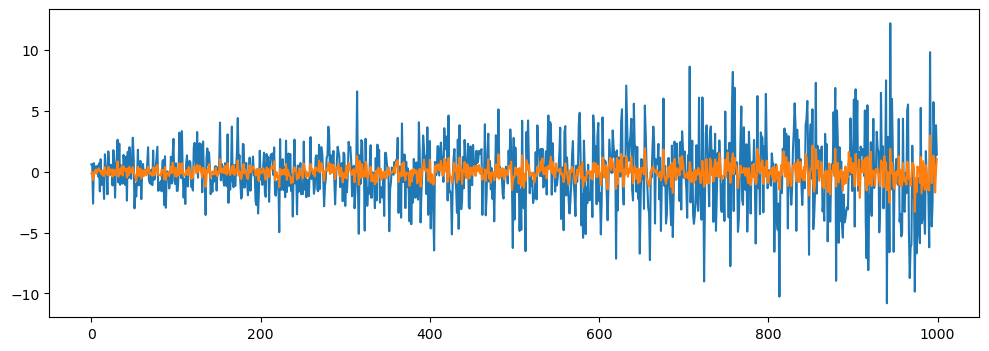

In [101]:
plt.figure(figsize=(12,4))
plt.plot(X @ filt_1_est)
plt.plot(X @ filt_0_est)

0.04098971162059327

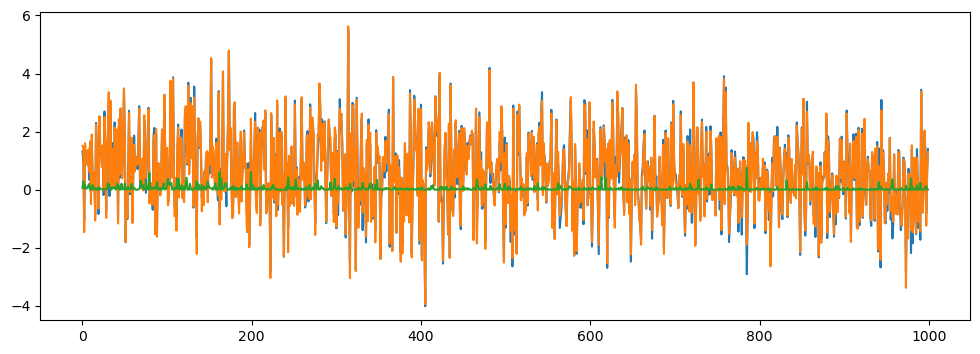

In [143]:
plt.figure(figsize=(12,4))
# plt.plot(Y)
plt.plot(Y_est)
plt.plot(X_filt.ravel())

plt.plot(((Y_est.ravel() - Y.ravel()) ** 2))
np.mean((Y_est.ravel() - Y.ravel()) ** 2)


In [12]:
model = FixedAdaptiveLinear(P, 1)
X_t = torch.tensor(X,dtype=torch.float32)
W_t = torch.tensor(W,dtype=torch.float32)
Y_t = torch.tensor(Y,dtype=torch.float32).reshape(N,1)
criterion=torch.nn.MSELoss()
learning_rate=0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.01, total_iters=2000)

In [13]:
epochs=2000
model.train()
for epoch in range(epochs):
    epoch+=1
    
    #convert numpy array to torch Variable
    optimizer.zero_grad()
    
    #Forward to get outputs
    outputs=model(X_t,W_t)
    
    #calculate loss
    loss=criterion(outputs, Y_t)
    
    #getting gradients wrt parameters
    loss.backward()
    
    #updating parameters
    optimizer.step()
    scheduler.step()
    
    if(epoch % 50 == 0):
        print('epoch {}, loss {}'.format(epoch, loss.data))

epoch 50, loss 0.0105241434648633
epoch 100, loss 0.009137637913227081
epoch 150, loss 0.009089234285056591
epoch 200, loss 0.009087284095585346
epoch 250, loss 0.009087195619940758
epoch 300, loss 0.009087192825973034
epoch 350, loss 0.009087192825973034
epoch 400, loss 0.009087192825973034
epoch 450, loss 0.009087192825973034
epoch 500, loss 0.009087193757295609
epoch 550, loss 0.009087192825973034
epoch 600, loss 0.009087193757295609
epoch 650, loss 0.009087192825973034
epoch 700, loss 0.009087193757295609
epoch 750, loss 0.009087193757295609
epoch 800, loss 0.009087192825973034
epoch 850, loss 0.009087193757295609
epoch 900, loss 0.009087192825973034
epoch 950, loss 0.009087193757295609
epoch 1000, loss 0.009087192825973034
epoch 1050, loss 0.009087193757295609
epoch 1100, loss 0.00908719189465046
epoch 1150, loss 0.009087192825973034
epoch 1200, loss 0.009087192825973034
epoch 1250, loss 0.009087192825973034
epoch 1300, loss 0.009087192825973034
epoch 1350, loss 0.0090871928259730

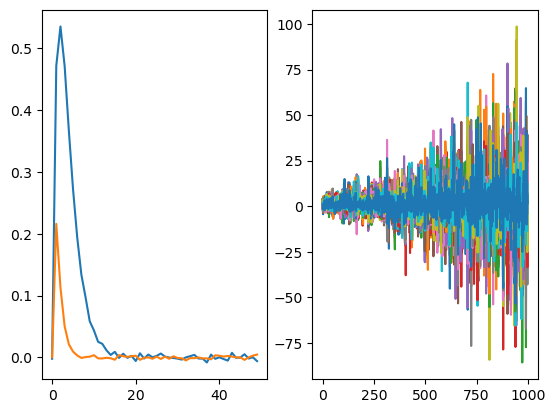

In [14]:
with torch.no_grad():
    filt_0_est = model.B_0.weight[0].numpy()
    filt_1_est = model.B_1.weight[0].numpy()
    Y_est = model(X_t,X_t).numpy()
plt.subplot(1,2,1)
plt.plot(filt_0_est)
plt.plot(filt_1_est)
plt.subplot(1,2,2)
plt.plot(Y)
plt.plot(Y_est);